# Important: This notebook must be ran with ros virtualenv

Play around with calibration in python with opencv

In [104]:
import cv2
import pathlib2 as pathlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set("notebook", rc={'figure.figsize':(11.7,8.27)})

img_dir = pathlib.Path('/home/hung/.optics_data/perception/capture/')

In [105]:
for img_path in img_dir.glob('calib_tooling*.png'):
    print(img_path)


/home/hung/.optics_data/perception/capture/calib_tooling_fused_image_11.png
/home/hung/.optics_data/perception/capture/calib_tooling_fused_image_6.png
/home/hung/.optics_data/perception/capture/calib_tooling_fused_image_5.png
/home/hung/.optics_data/perception/capture/calib_tooling_fused_image_1.png
/home/hung/.optics_data/perception/capture/calib_tooling_fused_image_9.png
/home/hung/.optics_data/perception/capture/calib_tooling_fused_image_26.png
/home/hung/.optics_data/perception/capture/calib_tooling_fused_image_25.png
/home/hung/.optics_data/perception/capture/calib_tooling_fused_image_12.png
/home/hung/.optics_data/perception/capture/calib_tooling_fused_image_3.png
/home/hung/.optics_data/perception/capture/calib_tooling_fused_image_14.png
/home/hung/.optics_data/perception/capture/calib_tooling_fused_image_15.png
/home/hung/.optics_data/perception/capture/calib_tooling_fused_image_18.png
/home/hung/.optics_data/perception/capture/calib_tooling_fused_image_20.png
/home/hung/.optic

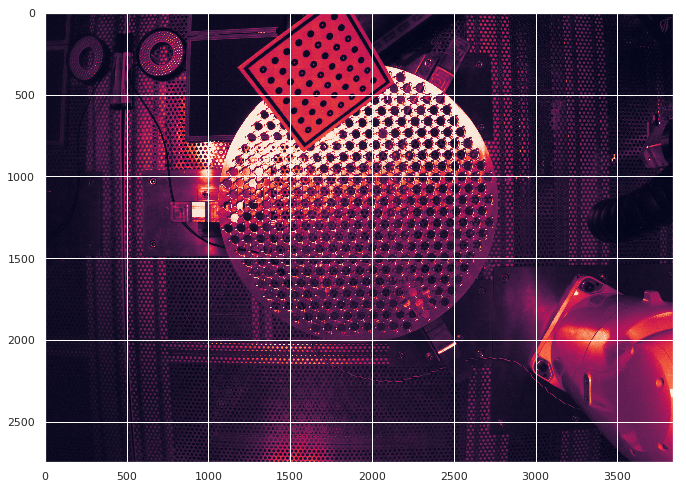

In [107]:
image1_path = list(img_dir.glob('*.png'))[0]
image1 = cv2.imread(image1_path.as_posix())
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)

# show image
plt.imshow(image1)
plt.show()

## Try blob detectors

params
<SimpleBlobDetector_Params 0x7f3c0dde36f0>
<type 'cv2.SimpleBlobDetector_Params'>


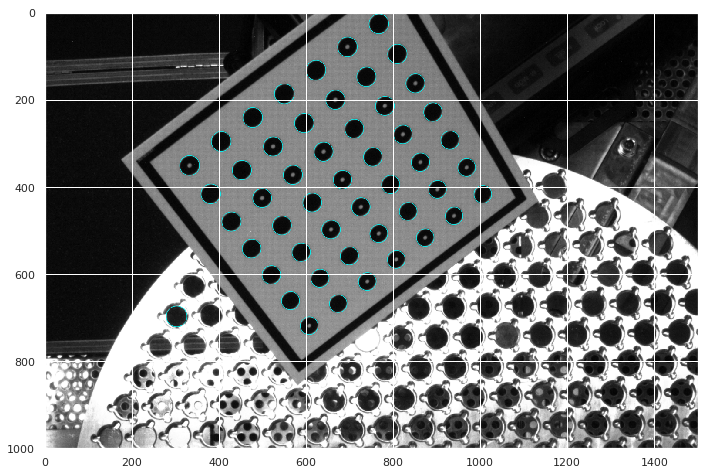

In [122]:
params = cv2.SimpleBlobDetector_Params()
# Setup SimpleBlobDetector parameters.
print('params')
print(params)
print(type(params))


# Filter by Area.
params.filterByArea = True
params.minArea = 1000
params.maxArea = 2000

params.minDistBetweenBlobs = 50


params.filterByColor = False

# tweak these as you see fit
# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.8
params.maxCircularity = 1.2

# # # Filter by Convexity
# params.filterByConvexity = True
# params.minConvexity = 0.87

# Filter by Inertia
# params.filterByInertia = True
# params.filterByInertia = False
# params.minInertiaRatio = 0.01

detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(image1)

import numpy as np
output = np.array(image1)
output = cv2.drawKeypoints(output, keypoints, output, (0, 255, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(output[:1000, 1000:2500])
plt.show()

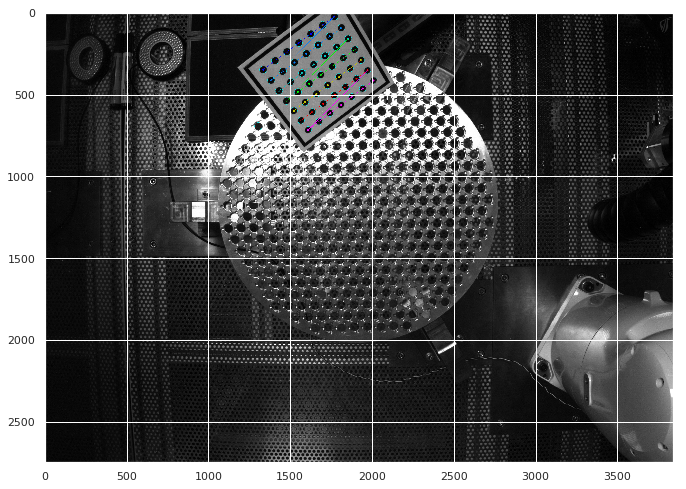

In [126]:
ret, corners = cv2.findCirclesGrid(image1, (7, 7), flags=cv2.CALIB_CB_SYMMETRIC_GRID, blobDetector=detector)
# Draw and display the corners
cv2.drawChessboardCorners(output, (7,7), corners, ret)
plt.imshow(output)
plt.show()

In [98]:
cv2.findCirclesGrid2?

## Calibrate cameras, now.

In [138]:
objp = np.zeros((7*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:7].T.reshape(-1,2) * 0.0185

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
for img_path in img_dir.glob('calib_tooling*.png'):
    img = cv2.imread(img_path.as_posix())
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findCirclesGrid(gray, (7, 7), flags=cv2.CALIB_CB_SYMMETRIC_GRID, blobDetector=detector)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (7,7), corners, ret)
        cv2.namedWindow('img', cv2.WINDOW_NORMAL)
        cv2.imshow('img', img)
        cv2.waitKey(500)
cv2.destroyAllWindows()

In [183]:
# calibrate
ret, intrinsics, distortions, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, gray.shape[::-1], None, None)

h, w = gray.shape
rectified_intrinsics, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
rectified_intrinsics = np.hstack((rectified_intrinsics, np.zeros((3, 1))))

In [184]:
rectified_intrinsics

array([[3.17614111e+03, 0.00000000e+00, 1.87116072e+03, 0.00000000e+00],
       [0.00000000e+00, 3.18539478e+03, 1.26323503e+03, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

In [191]:
calibrated_params = {
    "image_width": w,
    "image_height": h,
    'camera_name': 'basler',
    "camera_matrix": {
        "rows": 3,
        "cols": 3,
        "data": intrinsics.flatten().tolist()
    },
    "distortion_model": "plumb_bob",
    "distortion_coefficients": {
        "rows": 1,
        "cols": 5,
        "data": distortions.flatten().tolist()
    },
    "projection_matrix": {
        "rows": 3,
        "cols": 4,
        "data": rectified_intrinsics.flatten().tolist()
    }
}

import yaml
yaml.dump(calibrated_params, open('out.yaml', 'w'))

## Just some sanity check

In [192]:
mean_error = 0
for i in xrange(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error
print( "total error: {}".format(mean_error/len(objpoints)))

total error: 0.0128109484437


In [193]:
# undistort
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
cv2.namedWindow('img', cv2.WINDOW_NORMAL)
cv2.imshow('img', img)
cv2.waitKey(0)

cv2.imshow('img', dst)
cv2.waitKey(0)

cv2.destroyAllWindows()